In [1]:
import sys
import os

In [2]:
import datetime

In [3]:
import numpy
import scipy
import pandas

In [4]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [5]:
sys.path.append(os.path.join(os.path.abspath(os.path.join('../..')), 'src'))

In [21]:
import utils
import mysql_utils
import events_merge
import spectral_partition
import kernighan_lin

In [7]:
from importlib import reload

In [37]:
reload(mysql_utils)

<module 'mysql_utils' from '/home/immersinn/gits/rssfeed_link_collector/src/mysql_utils.py'>

## Prelims

### Create Sequence of dates of interest

In [8]:
base = datetime.datetime.strptime('2017-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')

In [9]:
date_list = [base + datetime.timedelta(hours=x) for x in range(0, 24*7, 6)]

In [10]:
date_list[:4]

[datetime.datetime(2017, 2, 1, 0, 0),
 datetime.datetime(2017, 2, 1, 6, 0),
 datetime.datetime(2017, 2, 1, 12, 0),
 datetime.datetime(2017, 2, 1, 18, 0)]

## Communities on Single Slice

### 00: Query and Prep Data

In [11]:
details ={'summary' : {'features' : ['title', 'summary'],
                       'cutoff' : 0.15,
                       'to_binary' : False,
                       'make_symmetric' : True, 'sym_func' : lambda x,y : (x+y)/2}
         }

In [12]:
out_01 = events_merge.process_timeslice_v2(mysql_utils.query_docsByDatetime(start_dt=date_list[0],
                                                                              end_dt=date_list[0 + 16]),
                                           details=details)
docids = out_01['summary']['doc_ids']
ts = out_01['summary']['tslice']

#### Test on Single Slice:

In [63]:
reload(spectral_partition)

<module 'spectral_partition' from '/home/immersinn/gits/rssfeed_link_collector/src/spectral_partition.py'>

In [13]:
tsg = scipy.sparse.csr_matrix((ts['vals'], ts['ij']))

In [14]:
# Density of matrix
tsg.nnz / tsg.shape[0] ** 2

0.008928544423440453

In [15]:
tsg.shape

(1150, 1150)

In [16]:
cci = numpy.where(tsg.sum(axis=1) > 0)[0]

In [17]:
tsg_cci = tsg[cci,:][:, cci]

In [18]:
tsg_cci.shape

(937, 937)

In [64]:
groups, counts, history = spectral_partition.spectralGraphPartition23(tsg_cci, Bin='bNG', L=1, finetune=False)

In [65]:
counts

{'threeway-pair': 0, 'twoway-pair': 27, 'twoway-single': 31}

In [28]:
h2 = history.copy()

In [29]:
def reorder_history_nodes(hhh):
    """
    <Stuffs here>
    """
    order_hist = []
    n_nodes, n_levels = hhh.shape
    
    prev_grps = [0]
    for lev in range(n_levels):
        if len(prev_grps)==1:
            new_order = numpy.argsort(hhh[:,0])
            hhh = hhh[new_order,:]
            prev_grps = list(numpy.unique(hhh[:,lev]))
            order_hist.append(new_order)
        else:
            new_order = []
            new_pgs = []
            start = 0
            for grp in prev_grps:
                # Subset of nodes in "grp" from previous step
                indx = hhh[:, lev-1] == grp
                # Order subset from "grp" based on current level assignments
                # and add 
                ns = [i + start for i in list(numpy.argsort(hhh[indx,lev]))]
                new_order.extend(ns)
                new_pgs.extend(list(numpy.unique(hhh[indx,lev])))
                start += len(ns)
            hhh = hhh[new_order,:]
            prev_grps = new_pgs
            order_hist.append(new_order)
            
    return(hhh)

In [30]:
h2 = reorder_history_nodes(h2)

In [59]:
len(numpy.unique(h2[:,-1]))

150

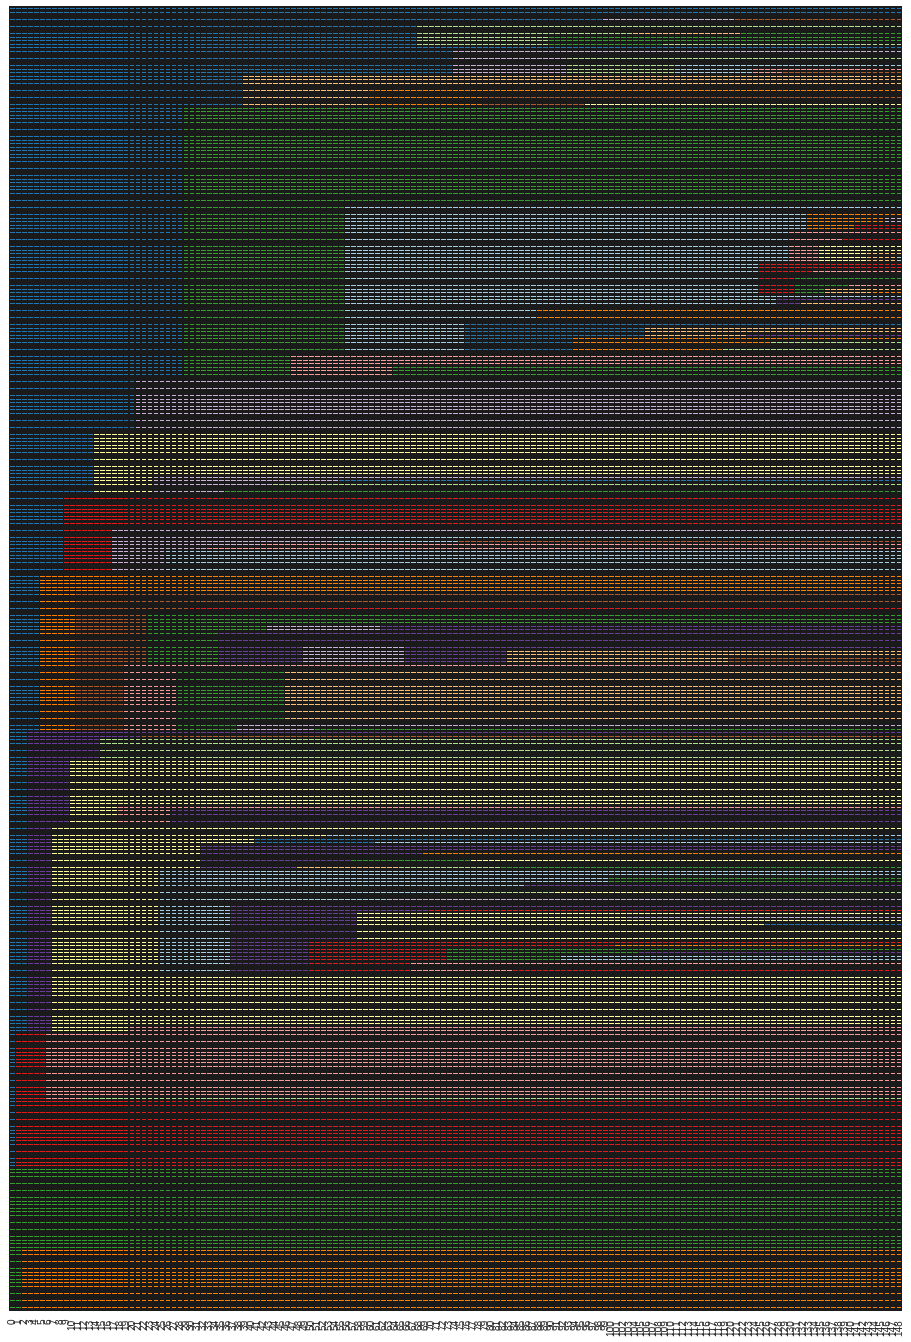

In [31]:
sns.set(style="white")

f, ax = plt.subplots()

# Draw the heatmap using seaborn
colors = sns.color_palette("Paired", n_colors=history.max())
main = [1,3,5,7,9] # "Paired"
#main = [0,1,2,3,4,5] # "bright"
nmain = [i for i in range(history.max()) if i not in main]
col, ors = [colors[i] for i in main], [colors[j] for j in nmain]
numpy.random.shuffle(ors)
colors = col; colors.extend(ors)
numpy.random.shuffle
g = sns.heatmap(h2, 
                cmap=mpl.colors.ListedColormap(colors),
                linecolor='k', linewidths=0.1,
                ax=ax, cbar=False, annot=False,
                yticklabels=False,
                );
#g.set(yticks=[]);
g.figure.set_size_inches(16, 24);

In [54]:
gps = history[:,-1]
c = 17
indxs = numpy.where(gps== c)[0]
grp = [docids[cci[i]] for i,v in enumerate((gps == c)) if v]
print(len(grp))

4


In [55]:
ddd = mysql_utils.query_docsDetails(grp, 
                                    fields=['link', 'title', 'summary', 'published', 'rss_link'],
                                    method='link')

In [56]:
ddd[['link', 'title', 'summary']].head(15)

,link,title,summary
0,http://www.bbc.co.uk/news/uk-northern-ireland-...,Terror accused Eamon Bradley 'never fired shot',A Londonderry man accused of terrorism in Syri...
1,http://www.bbc.co.uk/news/uk-northern-ireland-...,Syria terror accused Bradley 'walked free in D...,A Londonderry man accused of terrorism walked ...
2,http://www.cnn.com/2017/02/03/europe/france-pa...,Louvre knife attack: Authorities open terror i...,French authorities have opened a terror invest...
3,http://www.ft.com/cms/s/0/d1e8a51e-e9f5-11e6-9...,Louvre terror suspect identified as Egyptian,Trump warns of threat to US after knife-wieldi...


In [57]:
for s in ddd['title']:
    print(s)
    print('\n')

Terror accused Eamon Bradley 'never fired shot'


Syria terror accused Bradley 'walked free in Derry'


Louvre knife attack: Authorities open terror investigation


Louvre terror suspect identified as Egyptian




In [58]:
for s in ddd['summary']:
    print(s)
    print('\n')

A Londonderry man accused of terrorism in Syria told detectives he never fired a single shot against the enemy in his whole time there.


A Londonderry man accused of terrorism walked around the city freely for a week after he returned home from Syria, a court hears.


French authorities have opened a terror investigation after a soldier shot a man wielding a machete near the Louvre museum in Paris.<div class="feedflare">
<a href="http://rss.cnn.com/~ff/rss/cnn_world?a=EWlK1nX2w4g:TDnUeKUYP4g:yIl2AUoC8zA"><img src="http://feeds.feedburner.com/~ff/rss/cnn_world?d=yIl2AUoC8zA" border="0"></img></a> <a href="http://rss.cnn.com/~ff/rss/cnn_world?a=EWlK1nX2w4g:TDnUeKUYP4g:7Q72WNTAKBA"><img src="http://feeds.feedburner.com/~ff/rss/cnn_world?d=7Q72WNTAKBA" border="0"></img></a> <a href="http://rss.cnn.com/~ff/rss/cnn_world?a=EWlK1nX2w4g:TDnUeKUYP4g:V_sGLiPBpWU"><img src="http://feeds.feedburner.com/~ff/rss/cnn_world?i=EWlK1nX2w4g:TDnUeKUYP4g:V_sGLiPBpWU" border="0"></img></a> <a href="http://